### Load the dataset

In [1]:
from datasets import load_dataset

variant = 'hybrid'

# Load the custom dataset (or it if it does not exist)
# Param 1: location of the dataset loader script
# Param 2: location of cache folder, where the dataset will be saved
dataset = load_dataset(rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real\{variant}2real.py',
                       cache_dir=rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real')
print(f'Original dataset: \n{dataset}\n--------------------------')

dataset = dataset.remove_columns(['id', 'bboxes', 'image'])
print(f'Modified dataset: \n{dataset}')

Found cached dataset hybrid2real (C:/Users/Habram/Documents/Datasets_final/hybrid2real/hybrid2real/default/0.0.0/3b7df60835f91aeb5dd08a3beca752e3d91a10dfbe3607a7bfee7387513c5788)


  0%|          | 0/2 [00:00<?, ?it/s]

Original dataset: 
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 230
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 20
    })
})
--------------------------
Modified dataset: 
DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 230
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 20
    })
})


In [2]:
features = dataset["train"].features
label_column_name = "ner_tags"

# Define the dictionaries which associate the labels with integer IDs
label_list = features[label_column_name].feature.names
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}

### Extract the embeddings (output of the BERT model)

In [3]:
from transformers import BertTokenizer, BertModel
import torch

model = BertModel.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
SEQ_LENGTH = 512
CLS_ID = tokenizer.convert_tokens_to_ids("[CLS]")
SEP_ID = tokenizer.convert_tokens_to_ids("[SEP]")
PAD_ID = tokenizer.convert_tokens_to_ids("[PAD]")

def padding(input_ids):
    # Add the [CLS] and [SEP] tokens to the ends
    input_ids = [CLS_ID] + input_ids + [SEP_ID]
    # Fill the sequence with [PAD] until 512
    GAP = SEQ_LENGTH - len(input_ids)
    for _ in range(GAP):
        input_ids.append(PAD_ID)

    return [input_ids]

def truncating(input_ids, word2token):
    # Find how many splits are necessary
    # SEQ_LENGTH-2 -> CLS and SEP tokens should be added in every case
    num_splits = int(len(input_ids)/(SEQ_LENGTH-2))+1
    # Lists, where the splits are stored
    input_ids_all, word2token_all = [], []

    for _ in range(num_splits):
        # Find the boundary where the truncation is needed. If an entity is overlapping, push it to the next split
        for idx, group in enumerate(word2token):
            if group[1]-word2token[0][0] >= SEQ_LENGTH-2: 
                separator = group
                word2token_sub = word2token[0:idx]
                word2token = word2token[idx:]
                break
            if idx+1 == len(word2token):
                separator = group
                word2token_sub = word2token
                break 
        #
        input_ids_sub = input_ids[word2token_sub[0][0]:separator[0]]
        input_ids_sub = padding(input_ids_sub)[0]
        #input_ids = input_ids[separator[0]:]

        input_ids_all.append(input_ids_sub)
        word2token_all.append(word2token_sub)

    '''for kaki in input_ids_all:
        print(len(kaki), tokenizer.decode(kaki))
    for kaki in word2token_all:
        print(len(kaki), kaki)'''

    return input_ids_all, word2token_all

In [5]:
from torch import Tensor
from tqdm import tqdm
import numpy as np

dataset_splits = ['train', 'test']

# Dataset level
for split in dataset_splits:
    # Store all tokens, labels and grouped embeddings within a dataset split
    all_tokens, all_labels, all_embeddings = [], [], []

    # Document level
    for X, Y in tqdm(zip(dataset[split]['tokens'], dataset[split]['ner_tags'])):
        '''print('New document!')
        print('--------------')
        print(f'Num of words: {len(X)}')'''
        # Store token_ids, and word to token maps within a document
        input_ids, word2token = [], []

        # Token level
        for x, y in zip(X, Y):
            # Tokenize one word
            token_ids = tokenizer(x)["input_ids"]
            # Throw away [CLS] and [SEP]
            token_ids = token_ids[1: -1]
            
            # Build the input (throw away [CLS] and [SEP])
            n_tokens = len(token_ids)
            # Store info about which positions in the tokenized sequence the current input x belongs to
            span_start = len(input_ids)
            span_end = span_start + n_tokens

            input_ids.extend(token_ids)
            word2token.append((span_start, span_end))

        # Pad the sequence or Truncate the sequence
        if len(input_ids) < SEQ_LENGTH-2:
            input_ids = padding(input_ids)
            word2token = [word2token]
        else:
            input_ids, word2token = truncating(input_ids, word2token)

        num_splits = len(input_ids)
        mean_embeddings = []
        #print(f'Num of splits: {num_splits}')
        for sub in range(num_splits):
            #print('New split:')
            # Create the attention mask
            sep_idx = input_ids[sub].index(SEP_ID)
            att_mask = [1 if i < sep_idx else 0 for i in range(SEQ_LENGTH)]
            # Turn into tensors
            encoded_input = dict(
                input_ids = Tensor([input_ids[sub]]).int(),
                token_type_ids = Tensor([[0] * SEQ_LENGTH]).int(),
                attention_mask = Tensor([att_mask]).int(),
            )
            # Get the model output
            output = model(**encoded_input)
            # Turn last hidden state into numpy array
            embeddings = output.last_hidden_state.detach().numpy()
            # Remove the first and last embeddings
            embeddings = np.delete(embeddings[0], [0, -1], axis=0)
            # Now we can find out which embeddings correspond to a certain input
            for i, mapping in enumerate(word2token[sub]):
                mapping = (mapping[0] - word2token[sub][0][0], mapping[1] - word2token[sub][0][0])
                start, end = mapping
                current_embedding = embeddings[start:end]
                mean_embedding = current_embedding.mean(axis=0)
                mean_embeddings.append(mean_embedding)

        Y = torch.Tensor(Y)     
        Y = Y.type(torch.LongTensor)
        all_labels.append(Y)
        all_embeddings.append(np.array(mean_embeddings))
        all_tokens.append(X)

    # Save the embeddings, labels and tokens
    data = {
        'embeddings': all_embeddings,
        'tokens':     all_tokens,
        'labels':     all_labels
    }

    np.save(f'{variant}2real_{split}.npy', np.array(data, dtype=object), allow_pickle=True)

230it [05:54,  1.54s/it]
20it [00:41,  2.10s/it]


### Train a linear classifier

In [6]:
import numpy as np

training_data = np.load(f'{variant}2real_train.npy', allow_pickle=True).item()
testing_data = np.load(f'{variant}2real_test.npy', allow_pickle=True).item()

In [7]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class IstvoicesDataset(Dataset):
    def __init__(self, data):
        self.labels = data['labels']
        self.embeddings =  data['embeddings']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        lab = self.labels[idx]

        return torch.tensor(emb), torch.tensor(lab)
    
dataset_train_torch = IstvoicesDataset(training_data)
train_dataloader = DataLoader(dataset_train_torch, batch_size=1, shuffle=True)

dataset_test_torch = IstvoicesDataset(testing_data)
test_dataloader = DataLoader(dataset_test_torch, batch_size=1, shuffle=True)

In [8]:
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(768, 35)

    def forward(self, x):
        x = self.fc(x)
        return x

In [9]:
performance = {
    'train_loss': [],
    'test_loss': [],     
    'precision': [],
    'recall': [],
    'f1': [],
}

w = torch.FloatTensor([0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1])

size_of_dataset = len(training_data['embeddings'])
num_epochs = 2

In [10]:
from sklearn.metrics import precision_recall_fscore_support

net = Net()
criterion = nn.CrossEntropyLoss(weight=w)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
softmax = nn.Softmax(dim=1)

for epoch in range(num_epochs):
    for i in range(size_of_dataset):
        # Get the embeddings and the ground truth
        train_features, train_labels = next(iter(train_dataloader))

        # Perform a forward pass
        classifier_output = net(train_features)

        # Calculate the loss
        optimizer.zero_grad()
        loss = criterion(classifier_output[0], train_labels[0])

        # Perform a backward pass
        loss.backward()

        # Tune the parameters
        optimizer.step()

        # Evaluation
        if i % 20 == 0:
            sub_f1 = []
            sub_precision = []
            sub_accuracy = []
            sub_recall = []

            for test_idx in range(len(testing_data['embeddings'])):
                test_features, test_labels = next(iter(test_dataloader))
                predictions = net(test_features)
                predictions = softmax(predictions[0])
                predictions = torch.argmax(predictions, dim=1)

                prec, rec, f1, _ = precision_recall_fscore_support(y_true=test_labels[0], y_pred=predictions, average='weighted', zero_division=0.0)
                
                sub_f1.append(f1)
                sub_precision.append(prec)
                sub_recall.append(rec)
            performance['train_loss'].append(float(loss))
            performance['f1'].append(sum(sub_f1)/len(sub_f1))
            performance['recall'].append(sum(sub_recall)/len(sub_recall))
            performance['precision'].append(sum(sub_precision)/len(sub_precision))

C:\Users\Habram\AppData\Local\Temp\ipykernel_22008\351947249.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb), torch.tensor(lab)
C:\Users\Habram\AppData\Local\Temp\ipykernel_22008\351947249.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb), torch.tensor(lab)
C:\Users\Habram\AppData\Local\Temp\ipykernel_22008\351947249.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb), torch.tensor(lab)
C:\Users\Habram\AppData\Local\Temp\ipykernel_22008\351947249.py:17: Us

In [11]:
# Save the trained classifier
torch.save(net.state_dict(), rf'{variant}2real_classifier.pt')

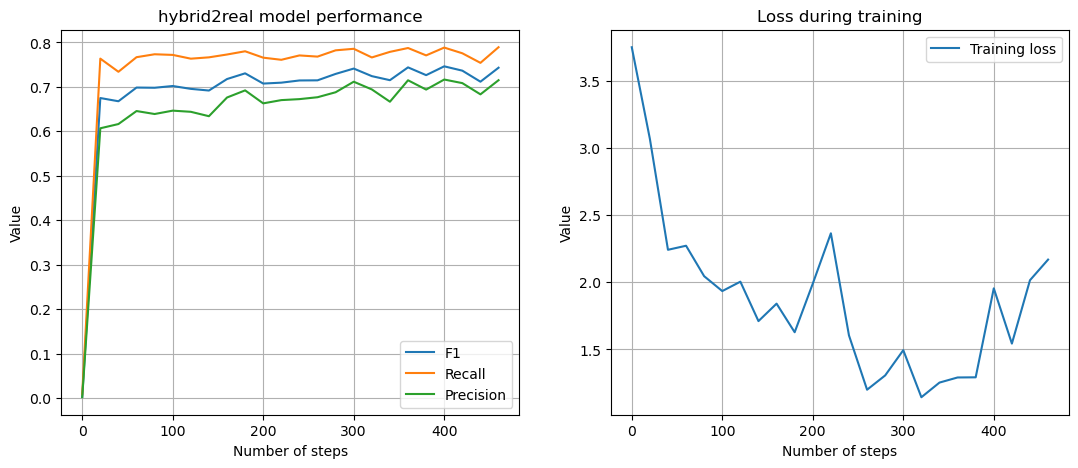

In [12]:
import matplotlib.pyplot as plt

x_axis = np.arange(len(performance['f1']))*20
 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(x_axis, performance['f1'], label='F1')
ax1.plot(x_axis, performance['recall'], label='Recall')
ax1.plot(x_axis, performance['precision'], label='Precision')
ax1.set_xlabel('Number of steps')
ax1.set_ylabel('Value')
ax1.set_title('hybrid2real model performance')
ax1.grid()
ax1.legend(loc=4)

ax2.plot(x_axis, performance['train_loss'], label='Training loss')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Value')
ax2.set_title('Loss during training')
ax2.grid()
ax2.legend(loc=1)

plt.show()

In [13]:
def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label.lower()

def get_all_predictions():
    all_labels = []
    all_predictions = []
    
    # iterate over the whole test set
    for test_idx in range(len(testing_data['embeddings'])):
        test_features, test_labels = next(iter(test_dataloader))
        predictions = net(test_features)
        predictions = softmax(predictions[0])
        predictions = torch.argmax(predictions, dim=1)
        predictions = predictions.numpy()
        test_labels = test_labels[0].numpy()

        # Get the actual labels (str)
        true_predictions = [id2label[pred] for pred, label in zip(predictions, test_labels)]
        true_labels      = [id2label[label] for pred, label in zip(predictions, test_labels)]

        all_labels.append(list(map(iob_to_label, true_labels)))
        all_predictions.append(list(map(iob_to_label, true_predictions)))

    return all_labels, all_predictions

all_labels, all_predictions = get_all_predictions()

all_labels = [item.lower() for sublist in all_labels for item in sublist]
all_predictions = [item.lower() for sublist in all_predictions for item in sublist]

C:\Users\Habram\AppData\Local\Temp\ipykernel_22008\351947249.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb), torch.tensor(lab)


In [14]:
label_list = ['other',
              'r_name', 'r_street', 'r_housenumber', 'r_zip', 'r_city', 'r_country',
              's_name', 's_street', 's_housenumber', 's_zip', 's_city', 's_country',
              's_bank', 's_iban','i_number','i_date', 'i_amount',]

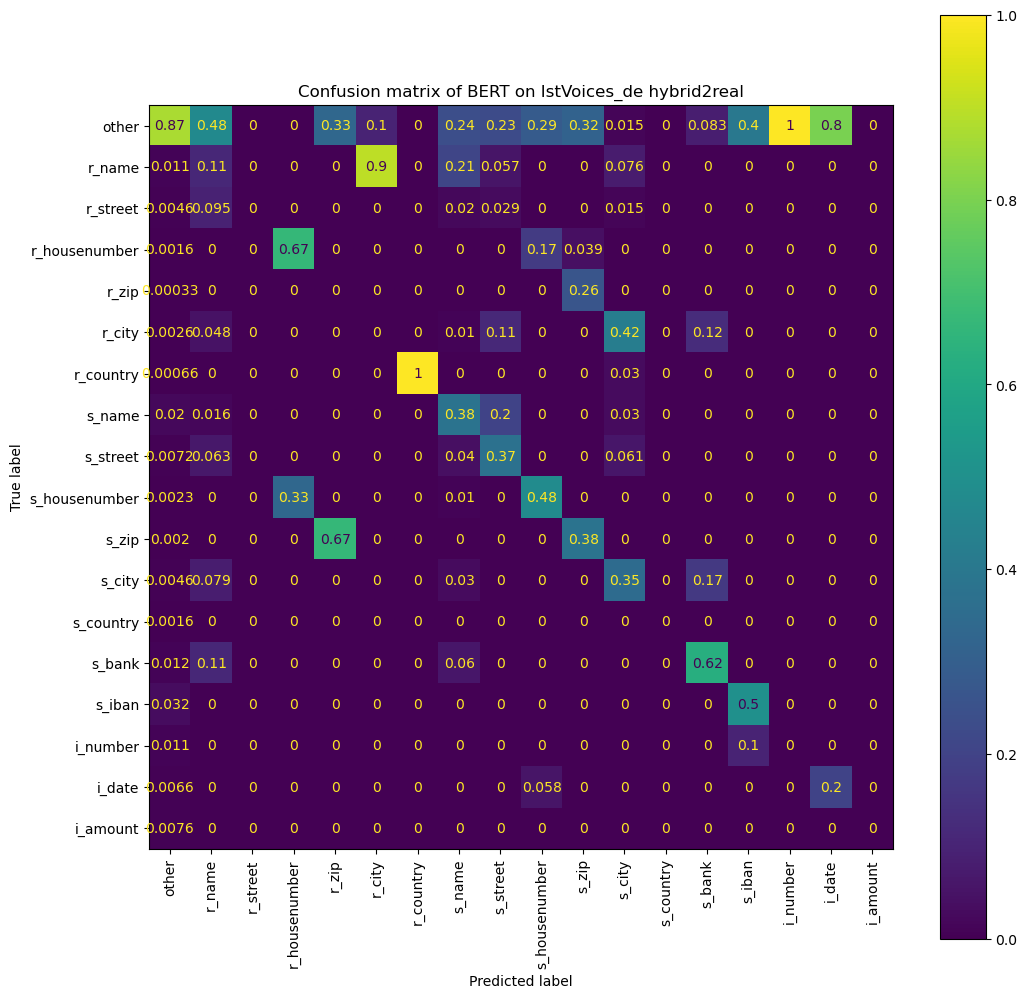

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_true=all_labels, y_pred=all_predictions, labels=label_list, normalize='pred')
cm_display = ConfusionMatrixDisplay(cm, display_labels=label_list)
cm_display.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion matrix of BERT on IstVoices_de hybrid2real')
plt.show()